In [1]:
import geopandas as gpd
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from shapely.geometry import Point, Polygon

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import os
import sys
module_path = os.path.abspath(os.path.join('../../'))
if module_path not in sys.path:
    sys.path.append(module_path)
    import aup

## Downloading network

In [2]:
USOS_ZONA_7 = gpd.read_file("USOS_ZONA_7.shp")

In [9]:
print(USOS_ZONA_7.crs)

EPSG:32613


In [3]:
# Convertir la geometría del polígono en WKT (para usar SQL en la query)
poly_wkt = USOS_ZONA_7.dissolve().geometry.iloc[0].wkt
# print(poly_wkt)  # Verificar si genera un WKT válido

In [6]:
schema = "denue"
table = "denue_2022"

manzana = "manzana"
entidad = "cve_ent"
localidad = "cve_loc"
municipio = "cve_mun"
id = "id"
latitud = "latitud"
longitud = "longitud"
codigo_act = "codigo_act"
ageb = "ageb"
per_ocu = "per_ocu"


# Crear la consulta manteniendo el mismo CRS
query_censo = f"""
SELECT 
  "{id}", 
  "{entidad}",
  "{localidad}",
  "{manzana}",
  "{municipio}",
  "{latitud}",
  "{longitud}",
  "{codigo_act}",
  "{ageb}",
  "{per_ocu}",
  "geometry"
FROM {schema}.{table}
WHERE ST_Intersects(
  ST_Transform(geometry, 32613),  -- Transformar geometría de DENUE a 32613 
  ST_GeomFromText('{poly_wkt}', 32613)  -- Usar el polígono en 32613
)
"""

# Ejecutar la consulta
Denue = aup.gdf_from_query(query_censo, geometry_col='geometry')

# Asegurar que el GeoDataFrame resultante tenga el CRS correcto
Denue.crs = "EPSG:32613"

print(Denue.shape)
Denue.head()


(1910, 11)


,id,cve_ent,cve_loc,manzana,cve_mun,latitud,longitud,codigo_act,ageb,per_ocu,geometry
0,8979075,14,0001,001,120,20.656107,-103.453573,311520,3607,0 a 5 personas,POINT (-103.454 20.656)
1,6146774,14,0001,025,120,20.645060,-103.446555,236211,1691,11 a 30 personas,POINT (-103.447 20.645)
2,1821794,14,0001,033,120,20.647822,-103.448950,311520,1691,6 a 10 personas,POINT (-103.449 20.648)
3,6146645,14,0001,008,120,20.655170,-103.451927,236111,3503,31 a 50 personas,POINT (-103.452 20.655)
4,1661305,14,0001,020,120,20.650230,-103.453850,312112,4535,6 a 10 personas,POINT (-103.454 20.650)


In [31]:
print(Denue.is_valid.sum())  # Geometrías válidas
print(Denue.geometry.is_empty.sum())  # Geometrías vacías

1910
0


In [7]:
# Verificar coordenadas extremas
print("\nRango de coordenadas USOS_ZONA_7:")
print(USOS_ZONA_7.total_bounds)
print("\nRango de coordenadas Denue:")
print(Denue.total_bounds)


Rango de coordenadas USOS_ZONA_7:
[ 657358.96724682 2280305.95642911  662900.34994682 2288463.39962911]

Rango de coordenadas Denue:
[-103.48262895   20.62208192 -103.43747004   20.687842  ]


## Clasificar las distintas actividades económicas con base en su terminación en "codigo_act" basándonos en el Directorio Estadístico Nacional de Unidades Económicas

In [8]:
# Función para clasificar según la terminación de codigo_act
def asignar_tipo(codigo):
    if pd.isna(codigo):  # Si está vacío
        return 'Sin código'
    
    # Asegurar que sea string para evaluar el código
    codigo_str = str(codigo).strip()

    if not codigo_str.isdigit():
        return 'Código inválido'
    
    # Define tus conjuntos de códigos
    industria = {'11', '21', '23', '31', '32', '33', '55'}
    
    servicios = {'22', '48', '49', '52', '53', '54', '56', '72',
                 '81'}
    
    comercio = {'43', '46'}
    
    cultural_recreativo = {'51','71'}
    
    educacion = {'61'}
    
    salud = {'62'}

    gobierno = {'93'}
    
    # Verificar si el código está en alguno de los conjuntos
    if codigo_str[:2] in industria:
        return 'Industria'
    elif codigo_str[:2] in servicios:
        return 'Servicios'
    elif codigo_str[:2] in comercio:
        return 'Comercio'
    elif codigo_str[:2] in cultural_recreativo:
        return 'Cultural/Recreativo'
    elif codigo_str[:2] in educacion:
        return 'Educación'
    elif codigo_str[:2] in salud:
        return 'Salud'
    elif codigo_str[:2] in gobierno:
        return 'Gobierno'
    else:
        return 'Desconocido'

# Aplica la función al DataFrame
Denue['tipo_act'] = Denue['codigo_act'].apply(asignar_tipo)

In [9]:
Denue.head(3)

,id,cve_ent,cve_loc,manzana,cve_mun,latitud,longitud,codigo_act,ageb,per_ocu,geometry,tipo_act
0,8979075,14,0001,001,120,20.656107,-103.453573,311520,3607,0 a 5 personas,POINT (-103.454 20.656),Industria
1,6146774,14,0001,025,120,20.645060,-103.446555,236211,1691,11 a 30 personas,POINT (-103.447 20.645),Industria
2,1821794,14,0001,033,120,20.647822,-103.448950,311520,1691,6 a 10 personas,POINT (-103.449 20.648),Industria


In [35]:
Denue["tipo_act"].unique()

array(['Industria', 'Servicios', 'Comercio', 'Cultural/Recreativo',
       'Educación', 'Salud', 'Gobierno'], dtype=object)

In [36]:
desconocidos = Denue[Denue['tipo_act'] == 'Desconocido']

# Mostrar los valores únicos de codigo_act que no clasificaron
desconocidos_codigos = desconocidos['codigo_act'].unique()

print("Códigos que quedaron como 'Desconocido':")
print(desconocidos_codigos)

Códigos que quedaron como 'Desconocido':
[]


In [39]:
# Contar cuántas veces aparece cada código no reconocido
desconocidos['codigo_act'].value_counts()

Series([], Name: count, dtype: int64)

In [40]:
# Total de registros marcados como 'Desconocido'
total_desconocidos = (Denue['tipo_act'] == 'Desconocido').sum()

print(f"Total de 'Desconocido': {total_desconocidos}")

Total de 'Desconocido': 0


### Relación espacio -> espacio

#### Mostrar de manera completa las relaciones y jerarquías entre los distintos espacios

In [10]:
jerarquia_completa = Denue[['cve_ent', 'cve_mun', 'cve_loc', 'ageb', 'manzana']].drop_duplicates().sort_values(by=['cve_ent', 'cve_mun', 'cve_loc', 'ageb', 'manzana'])

jerarquia_completa.head(10)

,cve_ent,cve_mun,cve_loc,ageb,manzana
170,14,120,0001,1687,001
193,14,120,0001,1687,002
1728,14,120,0001,1687,003
189,14,120,0001,1687,004
1057,14,120,0001,1687,005
188,14,120,0001,1687,007
75,14,120,0001,1687,009
303,14,120,0001,1687,011
100,14,120,0001,1687,012
1538,14,120,0001,1687,013


In [11]:
conteo_manzanas = jerarquia_completa.groupby(['cve_ent', 'cve_mun', 'cve_loc', 'ageb', 'manzana']) \
    .size().reset_index(name='cont_manzanas') #  Contar cuántas manzanas hay por agrupación y convertimos a string

In [12]:
conteo_manzanas.head(5)

,cve_ent,cve_mun,cve_loc,ageb,manzana,cont_manzanas
0,14,120,0001,1687,001,1
1,14,120,0001,1687,002,1
2,14,120,0001,1687,003,1
3,14,120,0001,1687,004,1
4,14,120,0001,1687,005,1


In [40]:
conteo_manzanas["cont_manzanas"].unique()

array([1])

In [13]:
# Extraer los primeros N dígitos de cada variable
jerarquia_completa['entidad_str'] = jerarquia_completa['cve_ent'].str[:2]  # 2 primeros dígitos de entidad
jerarquia_completa['municipio_str'] = jerarquia_completa['cve_mun'].str[:3]  # 3 primeros dígitos de municipio
jerarquia_completa['localidad_str'] = jerarquia_completa['cve_loc'].str[:4]  # 4 primeros dígitos de localidad
jerarquia_completa['ageb_str'] = jerarquia_completa['ageb'].str[:4]  # 4 primeros dígitos de AGEB
jerarquia_completa['manzana_str'] = jerarquia_completa['manzana'].str[:3]  # 3 primeros dígitos de manzana

In [14]:
jerarquia_completa['cod_16d'] = (
    jerarquia_completa['entidad_str'] + '-' +
    jerarquia_completa['municipio_str'] + '-' +
    jerarquia_completa['localidad_str'] + '-' +
    jerarquia_completa['ageb_str'] + '-' +
    jerarquia_completa['manzana_str']
)

In [15]:
jerarquia_completa[['entidad_str', 'entidad_str', 'municipio_str', 'ageb_str', 'manzana_str', 'cod_16d']].head()

,entidad_str,entidad_str,municipio_str,ageb_str,manzana_str,cod_16d
170,14,14,120,1687,001,14-120-0001-1687-001
193,14,14,120,1687,002,14-120-0001-1687-002
1728,14,14,120,1687,003,14-120-0001-1687-003
189,14,14,120,1687,004,14-120-0001-1687-004
1057,14,14,120,1687,005,14-120-0001-1687-005


In [16]:
Denue_completo = Denue.merge(
    jerarquia_completa)

Denue_completo.head(3)

,id,cve_ent,cve_loc,manzana,cve_mun,latitud,longitud,codigo_act,ageb,per_ocu,geometry,tipo_act,entidad_str,municipio_str,localidad_str,ageb_str,manzana_str,cod_16d
0,8979075,14,0001,001,120,20.656107,-103.453573,311520,3607,0 a 5 personas,POINT (-103.454 20.656),Industria,14,120,0001,3607,001,14-120-0001-3607-001
1,9052473,14,0001,001,120,20.656106,-103.453329,238190,3607,11 a 30 personas,POINT (-103.453 20.656),Industria,14,120,0001,3607,001,14-120-0001-3607-001
2,7113560,14,0001,001,120,20.656238,-103.453488,326160,3607,6 a 10 personas,POINT (-103.453 20.656),Industria,14,120,0001,3607,001,14-120-0001-3607-001


## Importar las manzanas de censo

In [17]:
schema = "sociodemografico"
table = "censo_inegi_20_mza"

entidad = "cve_ent"
localidad = "cve_loc"
municipio = "cve_mun"
manzana = "cve_mza"
ageb = "cve_ageb"
ambito = "ambito"
tipomza = "tipomza"

query_censo = f"""
SELECT 
"{entidad}",
"{manzana}",
"{localidad}",
"{municipio}",
"{ageb}",
"{ambito}",
"{tipomza}",
"geometry"
FROM {schema}.{table}
WHERE ST_Intersects(
  ST_Transform(geometry, 32613),  -- Transformar geometría de DENUE a 32613 
  ST_GeomFromText('{poly_wkt}', 32613)  -- Usar el polígono en 32613
)
"""

# Ejecutar la consulta y cargar los datos en un GeoDataFrame
censo_denue = aup.gdf_from_query(query_censo, geometry_col='geometry')
censo_denue.crs = "EPSG:32613"

print(censo_denue.shape)
censo_denue.head()

(1588, 8)


,cve_ent,cve_mza,cve_loc,cve_mun,cve_ageb,ambito,tipomza,geometry
0,14,035,0001,120,7309,Urbana,Típica,"POLYGON ((-103.482 20.634, -103.482 20.634, -1..."
1,14,017,0001,120,7281,Urbana,Típica,"POLYGON ((-103.482 20.651, -103.482 20.651, -1..."
2,14,018,0001,120,7281,Urbana,Típica,"POLYGON ((-103.482 20.651, -103.482 20.651, -1..."
3,14,006,0001,120,707A,Urbana,Típica,"POLYGON ((-103.479 20.623, -103.479 20.623, -1..."
4,14,001,0001,120,2295,Urbana,Típica,"POLYGON ((-103.469 20.640, -103.470 20.641, -1..."


### Contabilizar cuántas personas hay ejerciendo cada actividad económica

In [18]:
def number_of_jobs(per_ocu):
    jobs_dict = {'0 a 5 personas':3,
                '6 a 10 personas':8,
                '11 a 30 personas':20,
                '31 a 50 personas':40,
                '51 a 100 personas':75,
                '101 a 250 personas':175,
                '251 y más personas':325}
    per_ocu_num = jobs_dict[per_ocu]
    return per_ocu_num

In [19]:
Denue_completo['per_ocu_num'] = Denue_completo.per_ocu.apply(lambda per_ocu: number_of_jobs(per_ocu))
Denue_completo.head(2)

,id,cve_ent,cve_loc,manzana,cve_mun,latitud,longitud,codigo_act,ageb,per_ocu,geometry,tipo_act,entidad_str,municipio_str,localidad_str,ageb_str,manzana_str,cod_16d,per_ocu_num
0,8979075,14,0001,001,120,20.656107,-103.453573,311520,3607,0 a 5 personas,POINT (-103.454 20.656),Industria,14,120,0001,3607,001,14-120-0001-3607-001,3
1,9052473,14,0001,001,120,20.656106,-103.453329,238190,3607,11 a 30 personas,POINT (-103.453 20.656),Industria,14,120,0001,3607,001,14-120-0001-3607-001,20


### Hacer el match entre las manzanas del denue y las manzanas del censo

In [20]:
censo_denue.rename(columns = {"cve_ageb": "ageb"} , inplace = True)
censo_denue.rename(columns = {"cve_mza": "manzana"} , inplace = True)

In [23]:
# Filtrar solo las columnas relevantes de Denue_completo (EXCLUYENDO geometry)
columnas_deseadas = ['cve_ent', 'cve_mun', 'cve_loc', 'ageb', 'manzana', 
                     'codigo_act', 'per_ocu', 'cod_16d', 'per_ocu_num']
Denue_completo_filtrado = Denue_completo[columnas_deseadas]

# Hacer el merge conservando SOLO las geometrías originales de censo_denue
censo_denue_filtrado = censo_denue[['cve_ent', 'cve_mun', 'cve_loc', 'ageb', 'manzana', 'geometry']].merge(
    Denue_completo_filtrado.drop_duplicates(subset=['cve_ent', 'cve_mun', 'cve_loc', 'ageb', 'manzana']),
    on=['cve_ent', 'cve_mun', 'cve_loc', 'ageb', 'manzana'],
    how='left'
)

# Verificación
print(f"Geometrías originales conservadas: {censo_denue_filtrado.geometry.equals(censo_denue.geometry)}")
print(censo_denue_filtrado.shape)
censo_denue_filtrado.head(3)

Geometrías originales conservadas: True
(1588, 10)


,cve_ent,cve_mun,cve_loc,ageb,manzana,geometry,codigo_act,per_ocu,cod_16d,per_ocu_num
0,14,120,0001,7309,035,"POLYGON ((-103.482 20.634, -103.482 20.634, -1...",NaN,NaN,NaN,NaN
1,14,120,0001,7281,017,"POLYGON ((-103.482 20.651, -103.482 20.651, -1...",NaN,NaN,NaN,NaN
2,14,120,0001,7281,018,"POLYGON ((-103.482 20.651, -103.482 20.651, -1...",NaN,NaN,NaN,NaN


In [54]:
# Obtenemos las manzanas coincidentes (solo claves)
manzanas_coincidentes = pd.merge(
    censo_denue[['cve_ent', 'cve_mun', 'cve_loc', 'ageb', 'manzana']].drop_duplicates(),
    Denue_completo[['cve_ent', 'cve_mun', 'cve_loc', 'ageb', 'manzana']].drop_duplicates(),
    on=['cve_ent', 'cve_mun', 'cve_loc', 'ageb', 'manzana'],
    how='inner'
)

# Filtrar Denue_completo para manzanas coincidentes
Denue_completo_filtrado = Denue_completo.merge(
    manzanas_coincidentes,
    on=['cve_ent', 'cve_mun', 'cve_loc', 'ageb', 'manzana'],
    how='inner'
)

#  Seleccionar solo las columnas a añadir (eliminando duplicados por manzana)
columnas_para_añadir = Denue_completo_filtrado[
    ['cve_ent', 'cve_mun', 'cve_loc', 'ageb', 'manzana', 'per_ocu',  'codigo_act', 'cod_16d', 'per_ocu_num']
].drop_duplicates(subset=['cve_ent', 'cve_mun', 'cve_loc', 'ageb', 'manzana'])

#  Añadir al censo_denue (conservando su geometría original)
censo_denue_filtrado = censo_denue.merge(
    columnas_para_añadir,
    on=['cve_ent', 'cve_mun', 'cve_loc', 'ageb', 'manzana'],
    how='inner'
)

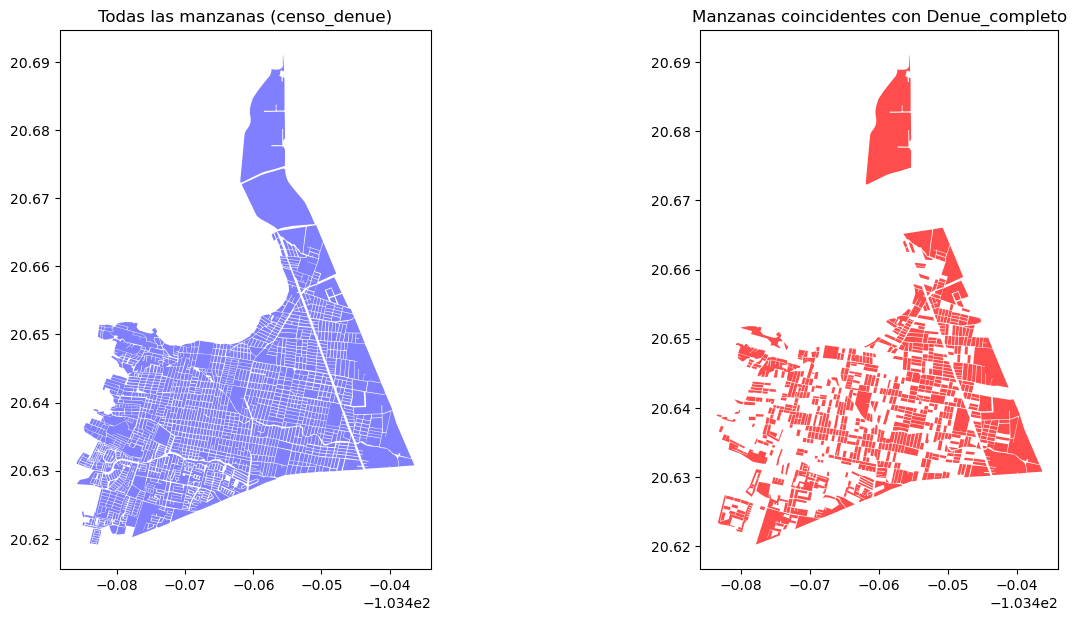

In [25]:
fig, ax = plt.subplots(1, 2, figsize=(15, 7))
censo_denue.plot(ax=ax[0], color='blue', alpha=0.5)
ax[0].set_title('Todas las manzanas (censo_denue)')
censo_denue_filtrado.plot(ax=ax[1], color='red', alpha=0.7)
ax[1].set_title('Manzanas coincidentes con Denue_completo')
plt.show()

In [52]:
censo_denue_filtrado.shape

(707, 12)

In [30]:
print(f"Manzanas originales en censo_denue: {len(censo_denue)}")
print(f"Manzanas coincidentes: {len(censo_denue_filtrado)}")
print(f"Manzanas en Denue_completo coincidentes: {len(Denue_completo_filtrado)}")

Manzanas originales en censo_denue: 1588
Manzanas coincidentes: 707
Manzanas en Denue_completo coincidentes: 1910


In [55]:
censo_denue_filtrado.head(3)

,cve_ent,manzana,cve_loc,cve_mun,ageb,ambito,tipomza,geometry,per_ocu,codigo_act,cod_16d,per_ocu_num
0,14,001,0001,120,2295,Urbana,Típica,"POLYGON ((-103.469 20.640, -103.470 20.641, -1...",0 a 5 personas,461110,14-120-0001-2295-001,3
1,14,021,0001,120,7309,Urbana,Típica,"POLYGON ((-103.478 20.638, -103.478 20.637, -1...",0 a 5 personas,461110,14-120-0001-7309-021,3
2,14,009,0001,120,7309,Urbana,Típica,"POLYGON ((-103.480 20.635, -103.480 20.635, -1...",0 a 5 personas,465311,14-120-0001-7309-009,3


## Crear centroides

In [56]:
# Calcular centroides de manzanas
manzanas_gdf = censo_denue_filtrado[['cve_ent', 'cve_mun', 'cve_loc', 'ageb', 'manzana', 'geometry']].drop_duplicates()
manzanas_gdf['centroide'] = manzanas_gdf['geometry'].centroid

# Unir con datos DENUE y calcular distancias
denue_con_distancias = Denue_completo_filtrado.merge(
    manzanas_gdf[['cve_ent', 'cve_mun', 'cve_loc', 'ageb', 'manzana', 'centroide']],
    on=['cve_ent', 'cve_mun', 'cve_loc', 'ageb', 'manzana'],
    how='left'
)
denue_con_distancias['distancia'] = denue_con_distancias.apply(
    lambda row: row['geometry'].distance(row['centroide']),
    axis=1
)

# 3. Calcular d_mean (manejo especial para manzanas con una sola actividad)
def calcular_d_mean(group):
    if len(group) == 1:  # Solo una actividad en la manzana
        return group['distancia'].iloc[0]
    else:
        total_personas = group['per_ocu_num'].sum()
        if total_personas > 0:
            return np.average(group['distancia'], weights=group['per_ocu_num'])
        return group['distancia'].mean()

d_mean_por_manzana = denue_con_distancias.groupby(
    ['cve_ent', 'cve_mun', 'cve_loc', 'ageb', 'manzana']
).apply(calcular_d_mean).reset_index(name='d_mean')

# Generar buffers (d_mean/2)
manzanas_con_buffer = manzanas_gdf.merge(
    d_mean_por_manzana,
    on=['cve_ent', 'cve_mun', 'cve_loc', 'ageb', 'manzana'],
    how='left'
)
manzanas_con_buffer['buffer'] = manzanas_con_buffer.apply(
    lambda row: row['centroide'].buffer(row['d_mean']/2) if not pd.isna(row['d_mean']) else None,
    axis=1
)

# Filtrar manzanas con buffer válido
manzanas_con_buffer = manzanas_con_buffer[manzanas_con_buffer['buffer'].notna()]

# Analizar qué DENUEs caen en cada buffer
resultados = []
for _, manzana in manzanas_con_buffer.iterrows():
    # Encontrar establecimientos dentro del buffer
    dentro_buffer = Denue_completo_filtrado[
        Denue_completo_filtrado['geometry'].within(manzana['buffer'])
    ]
    
    # Contar actividades diferentes
    conteo_actividades = dentro_buffer['codigo_act'].value_counts().to_dict()
    
    resultados.append({
        'cve_ent': manzana['cve_ent'],
        'cve_mun': manzana['cve_mun'],
        'cve_loc': manzana['cve_loc'],
        'ageb': manzana['ageb'],
        'manzana': manzana['manzana'],
        'codigo_act': censo_denue_filtrado['codigo_act'],
        'cod_16d': censo_denue_filtrado['cod_16d'],
        'd_mean': manzana['d_mean'],
        'radio_buffer': manzana['d_mean']/2,
        'total_establecimientos': len(dentro_buffer),
        'actividades_diferentes': conteo_actividades,
        'geometria_buffer': manzana['buffer']
    })

# Convertir a DataFrame
analisis_buffers = gpd.GeoDataFrame(resultados, geometry='geometria_buffer', crs=manzanas_gdf.crs)

# 7. Estadísticas y visualización
print("\nResumen de análisis:")
print(f"- Manzanas analizadas: {len(analisis_buffers)}")
print(f"- Establecimientos promedio por buffer: {analisis_buffers['total_establecimientos'].mean():.2f}")
print(f"- Radio promedio de buffers: {analisis_buffers['radio_buffer'].mean():.2f} unidades")


Resumen de análisis:
- Manzanas analizadas: 707
- Establecimientos promedio por buffer: 0.14
- Radio promedio de buffers: 0.00 unidades


In [57]:
analisis_buffers.head(3)

,cve_ent,cve_mun,cve_loc,ageb,manzana,codigo_act,cod_16d,d_mean,radio_buffer,total_establecimientos,actividades_diferentes,geometria_buffer
0,14,120,0001,2295,001,0 461110 1 461110 2 465311 3 ...,0 14-120-0001-2295-001 1 14-120-0001...,0.000442,0.000221,0,{},"POLYGON ((-103.469 20.641, -103.469 20.641, -1..."
1,14,120,0001,7309,021,0 461110 1 461110 2 465311 3 ...,0 14-120-0001-2295-001 1 14-120-0001...,0.000243,0.000121,0,{},"POLYGON ((-103.478 20.637, -103.478 20.637, -1..."
2,14,120,0001,7309,009,0 461110 1 461110 2 465311 3 ...,0 14-120-0001-2295-001 1 14-120-0001...,0.000211,0.000105,0,{},"POLYGON ((-103.481 20.635, -103.481 20.635, -1..."


In [40]:
analisis_buffers["total_establecimientos"].unique()

array([0, 2, 1, 5, 4, 3])

In [48]:
analisis_buffers["actividades_diferentes"].unique

<bound method Series.unique of 0                 {}
1                 {}
2                 {}
3                 {}
4                 {}
           ...      
702    {'611112': 1}
703    {'611112': 1}
704               {}
705               {}
706               {}
Name: actividades_diferentes, Length: 707, dtype: object>

/tmp/ipykernel_71770/75719858.py:9: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  Denue_completo_filtrado[


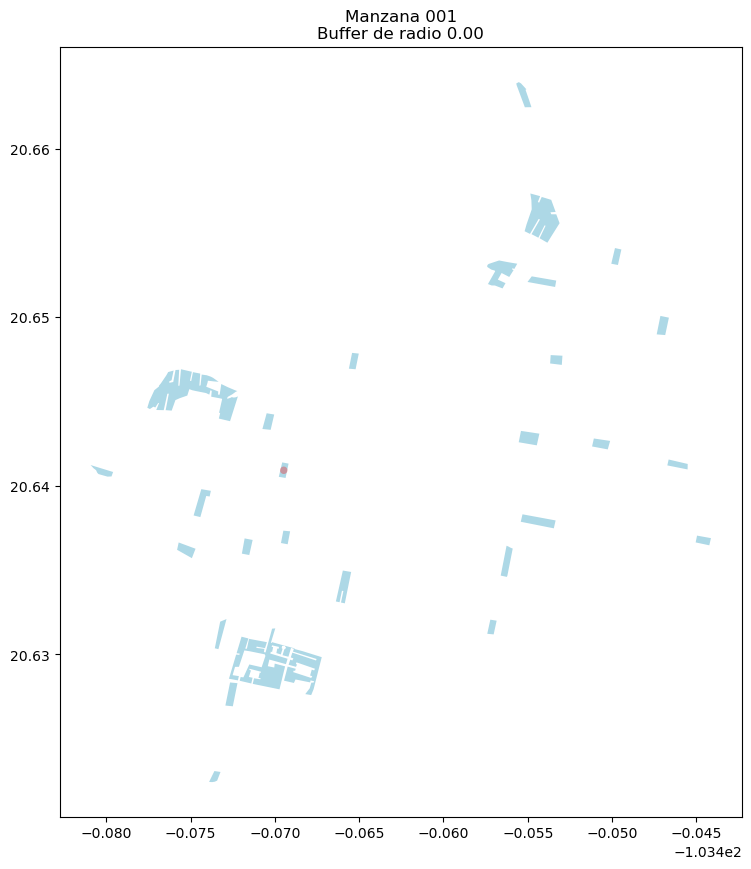

In [43]:
# Visualización de muestra

if not analisis_buffers.empty:
    muestra = analisis_buffers.iloc[0] # Visualizamos la primera manzana
    
    fig, ax = plt.subplots(figsize=(10, 10))
    manzanas_gdf[manzanas_gdf['manzana'] == muestra['manzana']].plot(ax=ax, color='lightblue')
    gpd.GeoDataFrame(geometry=[muestra['geometria_buffer']]).plot(ax=ax, color='red', alpha=0.3)
    Denue_completo_filtrado[
        Denue_completo_filtrado['geometry'].within(muestra['geometria_buffer'])
    ].plot(ax=ax, color='green', markersize=50)
    
    plt.title(f"Manzana {muestra['manzana']}\nBuffer de radio {muestra['radio_buffer']:.2f}")
    plt.show()

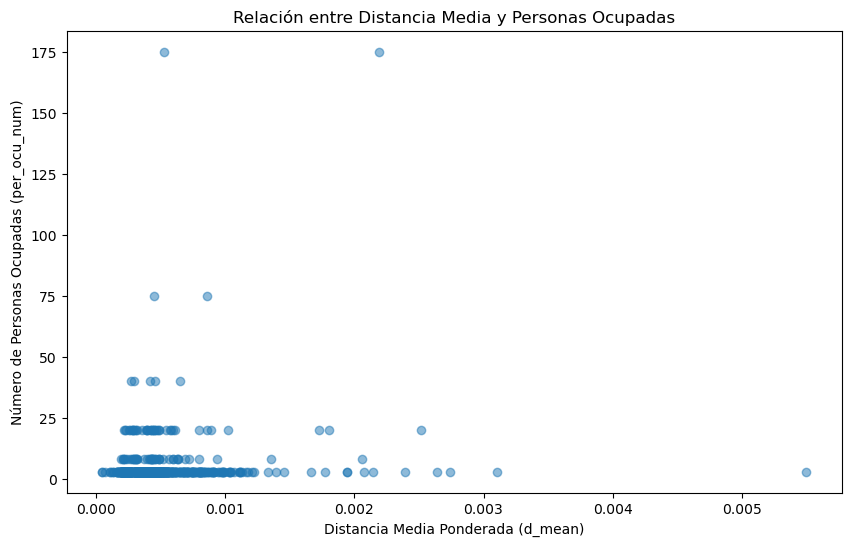

In [35]:
# 7. Visualización de relación entre d_mean y per_ocu_num
if not censo_denue_final.empty:
    import matplotlib.pyplot as plt
    plt.figure(figsize=(10, 6))
    plt.scatter(censo_denue_final['d_mean'], censo_denue_final['per_ocu_num'], alpha=0.5)
    plt.xlabel('Distancia Media Ponderada (d_mean)')
    plt.ylabel('Número de Personas Ocupadas (per_ocu_num)')
    plt.title('Relación entre Distancia Media y Personas Ocupadas')
    plt.show()